# Problem 1: Other activation functions (20%)
### The leaky Relu is defined as $max(0.1x, x)$. 
 - What is its derivative? (Please express in "easy" format")
 - Is it suitable for back propagation?
 
### $tanh$ is defined as  $\frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$. 
 - What is its derivative? (Please express in "easy" format")
 - Is it suitable for back propagation?
 - How is it different from the sigmoid activation

Leaky relu ------

Derivative 0.1 when x < 0 and 1 when x > 0

It is suitable for backpropagation as it fixes the dead neuron problem encountered with Relu. This happens when the weights are updated in such a way that they remain inactive during the rest of the training process

Tanh -------

Derivative of $tanh(x)$ is $1 - tanh(x)^2$

Tanh is a variant of sigmoid and is suitable for backpropagation. It is often thought to be more efficient than sigmoid because it is centered around zero and allows negative values. This provides more flexibility and can lead to faster convergence.

Tanh is linearly related to sigmoind. In fact it is a scaled version of sigmoid. Scaled between -1 and 1 (centered around zero), while sigmoid is contained between 0 and 1 and centered around 0.5

# Problem 2: Linear regression in Keras (40%)

#### We'd like to use keras to perform linear regression and compare it to another tool (scikit-learn)
#### We'll compare OLS, ridge ($L2$ regularization) and LASSO ($L1$ regularization) using both keras and scikit-learn


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# many of these imports to be removed
from keras.models import Model, Input
from keras.layers import Dense, Softmax, Dropout
from keras.regularizers import l1_l2
from keras.optimizers import RMSprop
import keras.backend as K

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [3]:
# Generate some data
np.random.seed(1024)
num_observations = 1024
coefs = np.array([-1.2, 5, 0, .22, 2, 0, 4])  # notice, there are zeros!
noise_amplitude = .05

num_variables = coefs.shape[0]

x = np.random.rand(num_observations, num_variables)
y = np.dot(x, coefs) + noise_amplitude * np.random.rand(num_observations)

cutoff = int(.8 * num_observations)
x_train, x_test = x[:cutoff], x[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

In [4]:
x_train.shape, y_train.shape

((819, 7), (819,))

In [5]:

# insert code to make predictions here
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg_predictions = lin_reg.predict(x_test)
mean_squared_error(y_test, lin_reg_predictions)

0.00020867822075987393

In [6]:
# Show that the coefficients are all close the the "real" ones used to generate the data
lin_reg_coefs = lin_reg.coef_
pd.Series(lin_reg_coefs, name='fit coefficients').to_frame().join(pd.Series(coefs, name='real coefficients')) 

,fit coefficients,real coefficients
0,-1.200971,-1.20
1,4.999581,5.00
2,-0.001820,0.00
3,0.217426,0.22
4,1.999645,2.00
5,-0.000385,0.00
6,4.000916,4.00


In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [8]:
# Now we will use keras to solve the same problem 
K.clear_session()
input_data = Input(shape=(x_train.shape[1],))
output = Dense(1, activation='linear')(input_data)
keras_lin_reg = Model(input_data, output)
keras_lin_reg.compile(optimizer=RMSprop(lr=2e-3, decay=1e-5), loss='mse', metrics=['accuracy'])
# don't forget to compile your model

In [9]:

# plot_model_in_notebook(keras_lin_reg)  # to be removed 

## How many parameters does the model have? 
### Explicitly show the calculation, explain it, and verify that it agrees with `model.count_params()`

In [10]:
# ADD CODE HERE
# 7 features plus one bias term -> 8 params
keras_lin_reg.count_params()

8

In [11]:
keras_lin_reg.fit(x_train, y_train, epochs=1000, verbose=0) 
mean_squared_error(y_test, keras_lin_reg.predict(x_test))

0.00021129568948177705

In [12]:
keras_lin_reg.layers[1].get_weights()[0]

array([[-1.2012897e+00],
       [ 4.9990849e+00],
       [-1.3780375e-03],
       [ 2.1758522e-01],
       [ 2.0002310e+00],
       [-1.0209600e-03],
       [ 4.0009909e+00]], dtype=float32)

In [13]:
# find the coefficients
keras_ols_coefs = keras_lin_reg.layers[1].get_weights()[0].flatten()

pd.Series(keras_ols_coefs, name='keras ols coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,keras ols coefficients,real coefficients
0,-1.201290,-1.20
1,4.999085,5.00
2,-0.001378,0.00
3,0.217585,0.22
4,2.000231,2.00
5,-0.001021,0.00
6,4.000991,4.00


## Now we will add some regularization

In [14]:
from keras.regularizers import l1_l2
regularizer = l1_l2(l1=0, l2=.01)
# Dense(...) -> Dense(..., kernel_regularizer=regularizer)
    
input_data = Input(shape=(x_train.shape[1],))
output = Dense(1, activation='linear', kernel_regularizer=regularizer)(input_data)
keras_ridge_model = Model(input_data, output)
keras_ridge_model.compile(optimizer=RMSprop(lr=2e-3, decay=1e-5), loss='mse', metrics=['accuracy'])
# don't forget to compile the model
# plot_model_in_notebook(keras_ridge_model)  # to be removed

In [15]:
keras_ridge_model.fit(x_train, y_train, epochs=1000, verbose=0, batch_size=256, shuffle=True)
mean_squared_error(y_test, keras_ridge_model.predict(x_test))

0.04331338001915001

In [16]:
keras_ridge_coefs = keras_ridge_model.layers[1].get_weights()[0].flatten()
pd.Series(keras_ridge_coefs, name='keras ridge coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,keras ridge coefficients,real coefficients
0,-1.084287,-1.20
1,4.441785,5.00
2,0.001209,0.00
3,0.213727,0.22
4,1.793655,2.00
5,0.021952,0.00
6,3.589289,4.00


In [18]:
# ridge regression in sklaern
from sklearn.linear_model import Ridge

sklearn_ridge_model = Ridge(alpha=0.01)
sklearn_ridge_model.fit(x_train, y_train)
sklearn_ridge_coefs = sklearn_ridge_model.coef_
pd.Series(sklearn_ridge_coefs, name='ridge coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,ridge coefficients,real coefficients
0,-1.200810,-1.20
1,4.998812,5.00
2,-0.001810,0.00
3,0.217429,0.22
4,1.999360,2.00
5,-0.000350,0.00
6,4.000354,4.00


In [20]:
# compare coefficients from various methods
pd.concat([
    pd.Series(sklearn_ridge_coefs, name='ridge coefs'),
    pd.Series(keras_ridge_coefs, name='keras L2 coefs'),
    pd.Series(coefs, name='real coefs')
], axis=1)

,ridge coefs,keras L2 coefs,real coefs
0,-1.200810,-1.084287,-1.20
1,4.998812,4.441785,5.00
2,-0.001810,0.001209,0.00
3,0.217429,0.213727,0.22
4,1.999360,1.793655,2.00
5,-0.000350,0.021952,0.00
6,4.000354,3.589289,4.00


## In fact, given the zero coefficients, LASSO might have been a better model. 
## LASSO uses $L_{1}$ regularization which will make sparse coefficients (some are zero).

In [21]:
from sklearn.linear_model import Lasso
# Add code here
sklearn_lasso_model = Lasso(alpha=0.01)
sklearn_lasso_model.fit(x_train, y_train)
sklearn_lasso_coefs = sklearn_lasso_model.coef_
pd.Series(sklearn_lasso_coefs, name='lasso coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,lasso coefficients,real coefficients
0,-1.088840,-1.20
1,4.871075,5.00
2,0.000000,0.00
3,0.107322,0.22
4,1.880817,2.00
5,-0.000000,0.00
6,3.897209,4.00


In [22]:
# now do lasso with keras
regularizer = l1_l2(l1=0.01, l2=0)

input_data= Input(shape=(x_train.shape[1],))
output = Dense(1, activation='linear', kernel_regularizer=regularizer)(input_data)
keras_lasso_model = Model(input_data, output)
keras_lasso_model.compile(optimizer=RMSprop(lr=2e-3, decay=1e-5), loss='mse', metrics=['accuracy'])
# don't forget to compile the model
# plot_model_in_notebook(keras_lasso_model)

In [23]:
keras_lasso_model.fit(x_train, y_train, epochs=1000, batch_size=256, verbose=False, shuffle=True)
keras_lasso_coefs = keras_lasso_model.layers[1].get_weights()[0].flatten()

In [24]:
# compare all the coefficients
pd.concat([
    pd.Series(sklearn_ridge_coefs, name='ridge coefs'),
    pd.Series(keras_ridge_coefs, name='keras L2 coefs'),
    pd.Series(sklearn_lasso_coefs, name='lasso coefs'),
    pd.Series(keras_lasso_coefs, name='keras L1 coefs'),
    pd.Series(lin_reg.coef_, name='ols coefs'),
    pd.Series(coefs, name='real coefs'),
], axis=1)

,ridge coefs,keras L2 coefs,lasso coefs,keras L1 coefs,ols coefs,real coefs
0,-1.200810,-1.084287,-1.088840,-1.144882,-1.200971,-1.20
1,4.998812,4.441785,4.871075,4.935797,4.999581,5.00
2,-0.001810,0.001209,0.000000,0.001233,-0.001820,0.00
3,0.217429,0.213727,0.107322,0.162128,0.217426,0.22
4,1.999360,1.793655,1.880817,1.938848,1.999645,2.00
5,-0.000350,0.021952,-0.000000,-0.000774,-0.000385,0.00
6,4.000354,3.589289,3.897209,3.948188,4.000916,4.00


In [25]:
# TODO(find optimal regularization paramter) ?

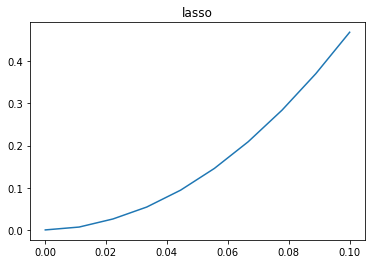

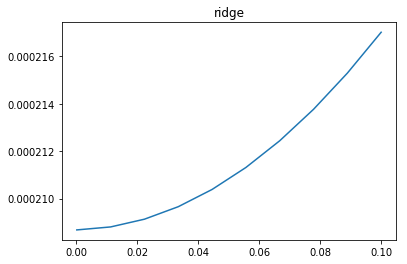

In [26]:
# Iterate throught different reg alpha and observe results... 
# Looking at out of sample performance is a bit of look ahead.
# Can uncomment to score using the squared diff of weights

mse_out_sample_score = True  # Set to true to look at out of sample MSE

res_df = pd.DataFrame()
for l in np.linspace(1e-4, 0.1, 10):
    lasso = Lasso(alpha=l).fit(x_train, y_train)#.coef_
    ridge = Ridge(alpha=l).fit(x_train, y_train)#.coef_
#     score_l = np.sum((lasso - coefs)**2)
#     score_r = np.sum((ridge - coefs)**2)
    if mse_out_sample_score:
        score_l = mean_squared_error(y_test, lasso.predict(x_test))
        score_r = mean_squared_error(y_test, ridge.predict(x_test))
    else:
        score_l = mean_squared_error(y_train, lasso.predict(x_train))
        score_r = mean_squared_error(y_train, ridge.predict(x_train))
    res_df.loc[l, "Lasso"] = score_l
    res_df.loc[l, "Ridge"] = score_r
    
    

res_df['Lasso'].plot(title="lasso")
plt.show()
res_df['Ridge'].plot(title="ridge")
plt.show()

In [27]:
# Regularization does not seem to improve results... Regular OLS could be the best model

# Problem 3: Keras for harder mnist problems (40%)
#### The deep net during lecture has a hard time distiguishing between 9 and 4.
#### We will build an algorithm to do this binary classification task 

In [195]:
# safe to restart here

In [196]:
import numpy as np
import pandas as pd
%pylab inline

# many of these to be removed
from keras.datasets import mnist
from keras.models import Model, Input
from keras.layers import Dense, Softmax, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l1_l2
from keras.optimizers import RMSprop
import keras.backend as K

Populating the interactive namespace from numpy and matplotlib


In [197]:
from keras.utils import to_categorical

def preprocess_training_data(data):
    data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    data = data.astype('float32') / 255
    return data

def preprocess_targets(target, num_classes):
    return to_categorical(target, num_classes)


def subset_to_9_and_4(x, y):  # this is a new function
    mask = (y == 9) | (y == 4)
    new_x = x[mask]
    new_y = (y[mask] == 4).astype('int64')
    return new_x, new_y

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess_training_data(x_train)
x_test = preprocess_training_data(x_test)

num_classes = np.unique(y_train).shape[0]

y_train_ohe = preprocess_targets(y_train, num_classes)
y_test_ohe = preprocess_targets(y_test, num_classes)

train_frac = 0.8
cutoff = int(x_train.shape[0] * train_frac)
x_train, x_val = x_train[:cutoff], x_train[cutoff:]
y_train, y_val = y_train[:cutoff], y_train[cutoff:]
y_train_ohe, y_val_ohe = y_train_ohe[:cutoff], y_train_ohe[cutoff:]

x_train, y_train = subset_to_9_and_4(x_train, y_train)
x_val, y_val = subset_to_9_and_4(x_val, y_val)
x_test, y_test = subset_to_9_and_4(x_test, y_test)

print(x_train.shape)

(9457, 784)


In [198]:
# first try logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Add code here

sklearn_lr_model = LogisticRegression()
sklearn_lr_model.fit(x_train, y_train)

sklearn_lr_predictions = sklearn_lr_model.predict(x_test)
accuracy_score(y_test, sklearn_lr_predictions)

0.9728779507785033

In [199]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [270]:
K.clear_session()
num_hidden_units = 512  
digit_input = Input(shape=(x_train.shape[1],))
x = Dense(num_hidden_units, activation=LeakyReLU(0.1))(digit_input)
# x = Dropout(rate=0.2, seed=42)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(digit_input, output)

#NB: you probably want BINARY cross entropy i.e. 'binary_crossentropy' for the loss function
model.compile(optimizer=RMSprop(lr=2e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

/Users/Hugo/anaconda3/envs/personal/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [271]:
# plot_model_in_notebook(model)

In [272]:
# how many params does the model have? 
print(784 * 512 + 512 + 512 *1)
model.count_params()

402432


402433

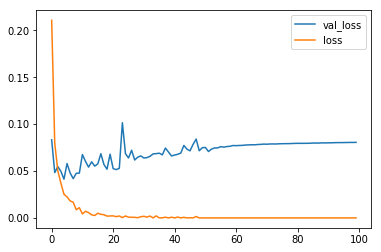

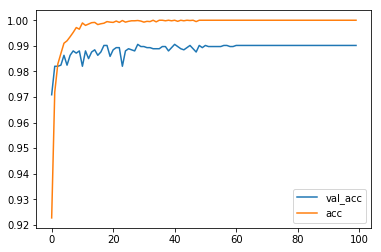

In [273]:
# Add code here
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=128, shuffle=True, verbose=0)

pd.DataFrame(model.history.history)[['val_loss', 'loss']].plot()
pd.DataFrame(model.history.history)[['val_acc', 'acc']].plot()

keras_predictions = model.predict(x_test)

In [274]:
# Mapping continuous probability to a label
keras_predictions[keras_predictions <= 0.5]  = 0
keras_predictions[keras_predictions > 0.5]  = 1

In [275]:
from sklearn.metrics import f1_score, accuracy_score
accuracy_score(y_test, keras_predictions)

0.9904570567553993

In [ ]:
# DONE! Congrats!